In [1]:
import wave,os,librosa,tqdm,time,warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from cuml.svm import SVC as cuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
import IPython.display as ipd

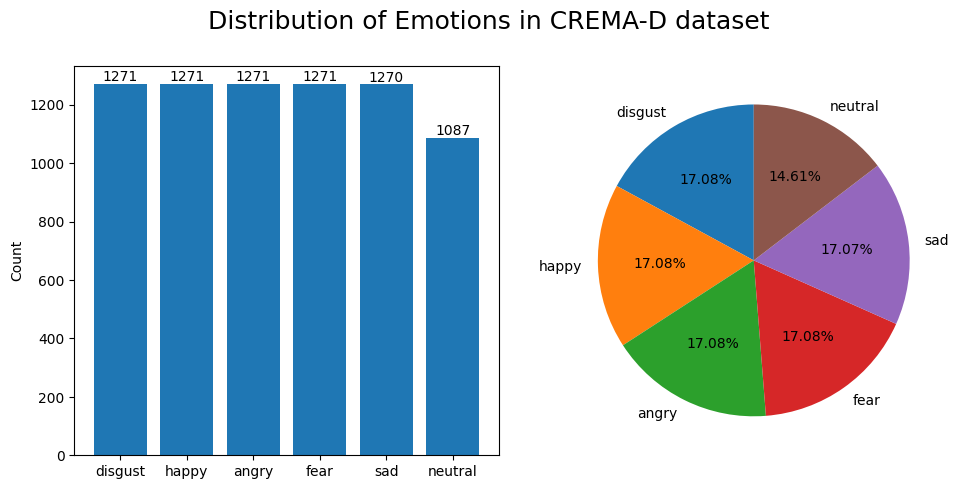

In [3]:
df = pd.read_csv('/kaggle/input/crema-d-mfcc-etc-features-trim-nr/CREMA_D_MFCC_etc_features_trim_NR.csv')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(df['label'].value_counts().index, df['label'].value_counts().values)
plt.ylabel("Count")
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),bar.get_height(), ha='center', va='bottom')
plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie',autopct='%1.2f%%',startangle=90)
plt.ylabel('')
plt.suptitle('Distribution of Emotions in CREMA-D dataset', fontsize=18)
plt.tight_layout(pad=1.5)
plt.show()

In [4]:
xmfs = df[[c for c in df.columns if c.startswith("mfs")]]
xmfcc = df[[c for c in df.columns if c.startswith("mfcc")]]
xzcr = df[[c for c in df.columns if c.startswith("zcr")]]
xrmse = df[[c for c in df.columns if c.startswith("rms")]]
xchr = df[[c for c in df.columns if c.startswith("chroma")]]
xspc = df[[c for c in df.columns if c.startswith("spectral_contrast")]]
xton = df[[c for c in df.columns if c.startswith("tonnetz")]]
xall = df.drop('label',axis=1)
y = df['label']

In [5]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True,hppms=None):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  try:
      model.fit(trainX, trainY)
  except TypeError:
      return 0
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

In [6]:
def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [7]:
def getRandparams(mname):
    if mname == 'SVM':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.01), np.log10(10)),
            'kernel': np.random.choice(['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.0003)),
            'coef0': 10**np.random.uniform(0, np.log10(0.1)),
            'class_weight': np.random.choice(['balanced', None]),
            'decision_function_shape': np.random.choice(['ovo', 'ovr']),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'XGBoost':
        model_params = {
            'learning_rate': np.random.uniform(0.01, 0.5),
            'n_estimators': np.random.randint(50, 200),
            'max_depth': np.random.randint(3, 20),
            'min_child_weight': np.random.randint(1, 10),
            'gamma': np.random.uniform(0, 1),
            'subsample': np.random.uniform(0.3, 1),
            'colsample_bytree': np.random.uniform(0.5, 1),
            'reg_alpha': np.random.uniform(0, 1),
            'reg_lambda': np.random.uniform(0, 1),
            'scale_pos_weight': np.random.uniform(1, 15),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'LogisticRegression':
        model_params = {
            'C': 10**np.random.uniform(np.log10(0.001), np.log10(10)),
            'solver': np.random.choice(['newton-cg', 'lbfgs', 'sag', 'saga']),
            'class_weight': np.random.choice(['balanced', None]),
            'penalty': np.random.choice(['l1', 'l2', 'elasticnet', None]),
            'random_state': np.random.randint(0, 1000),
        }
        if model_params['solver'] in ['lbfgs','sag','newton-cg']:
            model_params['penalty'] = np.random.choice(['l2', None])
        if model_params['penalty']=='elasticnet':
            model_params['solver'] = 'saga'
    elif mname == 'RandomForest':
        model_params = {
            'n_estimators': np.random.randint(50, 600),
            'max_depth': np.random.randint(3, 50),
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice(['sqrt', 'log2', None]),
            'bootstrap': np.random.choice([True, False]),
            'class_weight': np.random.choice(['balanced', 'balanced_subsample', None]),
            'random_state': np.random.randint(0, 1000),
        }
    elif mname == 'KNN':
        model_params = {
            'n_neighbors': np.random.randint(3, 40),
            'weights': np.random.choice(['uniform', 'distance']),
            'algorithm': np.random.choice(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': np.random.randint(20, 50),
            'p': np.random.choice([1, 2]),  # Minkowski metric (p=1 for Manhattan, p=2 for Euclidean)
        }
    elif mname == 'DecisionTree':
        model_params = {
            'criterion': np.random.choice(['gini', 'entropy', 'log_loss']),
            'splitter': np.random.choice(['best', 'random']),
            'max_depth': np.random.randint(3, 50),
            'min_samples_split': np.random.randint(2, 20),
            'min_samples_leaf': np.random.randint(1, 10),
            'max_features': np.random.choice([None, 'sqrt', 'log2']),
            'random_state': np.random.randint(0, 1000),
        }
    else:
        raise ValueError(f"Unsupported model name: {mname}")
    
    return model_params


In [8]:
def tune_ML_hppms(mname,model,iters=20,rs=None):
    hpr = []
    max_acc = 0
    best_model_params,best_prep_params,phist = dict(),dict(),dict()
    st0 = time.time()
    all_params = dict()
    for k in range(iters):
        st = time.time()
        model_params = getRandparams(mname)
        prep_params = {'rs':np.random.randint(0, 1000),
                       'apply_smote':np.random.choice([True,False]),
                        'apply_LDA':np.random.choice([True,False])}
        if rs:
            prep_params['rs'] = rs
        all_params = {**model_params, **prep_params}
        fparams = frozenset(all_params.items())
        #update model params
        model.set_params(**model_params)
        print(f"Iter No. - {k}")
        print(f"Model Params = {model_params}")
        print(f"Preprocessing Params = {prep_params}")
        acc = preprocess_split_train_test(df,model,mname,**prep_params,printres=False)
        en = time.time()
        tm = en-st
        tm0 = en-st0
        print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
        ipd.clear_output(wait=True)
        print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
        phist[fparams] = acc
        if acc>max_acc:
            max_acc = acc
            best_model_params = model_params
            best_prep_params = prep_params
            best_iter = k
        print(f"\nCurrent Accuracy = {acc*100:.2f}%")
        print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
        print(f"Best Model Params Found so far = {best_model_params}\n")
        print(f"Best Preprocessing Params Found so far = {best_prep_params}\n")
    print("Hyperparameter Tuning Done!")
    model.set_params(**best_model_params)
    acc = preprocess_split_train_test(df,model,mname,**best_prep_params)
    return max_acc,best_model_params,best_prep_params

Total Time taken = 1 min 57 sec

Current Accuracy = 46.14%
Best Accuracy = 47.15% at iter=86
Best Model Params Found so far = {'n_neighbors': 32, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 49, 'p': 2}

Best Preprocessing Params Found so far = {'rs': 806, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


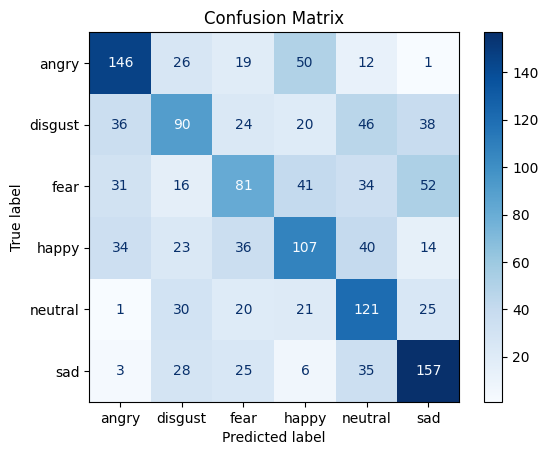


KNN Accuracy: 47.146%
              precision    recall  f1-score   support

       angry       0.58      0.57      0.58       254
     disgust       0.42      0.35      0.39       254
        fear       0.40      0.32      0.35       255
       happy       0.44      0.42      0.43       254
     neutral       0.42      0.56      0.48       218
         sad       0.55      0.62      0.58       254

    accuracy                           0.47      1489
   macro avg       0.47      0.47      0.47      1489
weighted avg       0.47      0.47      0.47      1489



In [8]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=100)

Total Time taken = 3 min 56 sec

Current Accuracy = 47.41%
Best Accuracy = 47.68% at iter=10
Best Model Params Found so far = {'n_neighbors': 25, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 29, 'p': 1}

Best Preprocessing Params Found so far = {'rs': 806, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


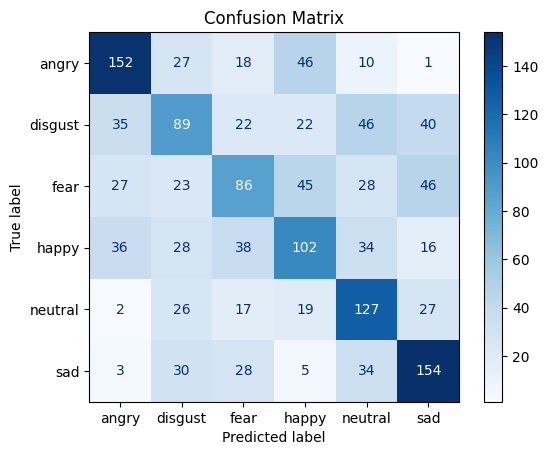


KNN Accuracy: 47.683%
              precision    recall  f1-score   support

       angry       0.60      0.60      0.60       254
     disgust       0.40      0.35      0.37       254
        fear       0.41      0.34      0.37       255
       happy       0.43      0.40      0.41       254
     neutral       0.46      0.58      0.51       218
         sad       0.54      0.61      0.57       254

    accuracy                           0.48      1489
   macro avg       0.47      0.48      0.47      1489
weighted avg       0.47      0.48      0.47      1489



In [9]:
knn_model = KNeighborsClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('KNN',knn_model,iters=200,rs=806)

Total Time taken = 1 min 21 sec

Current Accuracy = 33.45%
Best Accuracy = 43.99% at iter=1
Best Model Params Found so far = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': None, 'random_state': 983}

Best Preprocessing Params Found so far = {'rs': 120, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


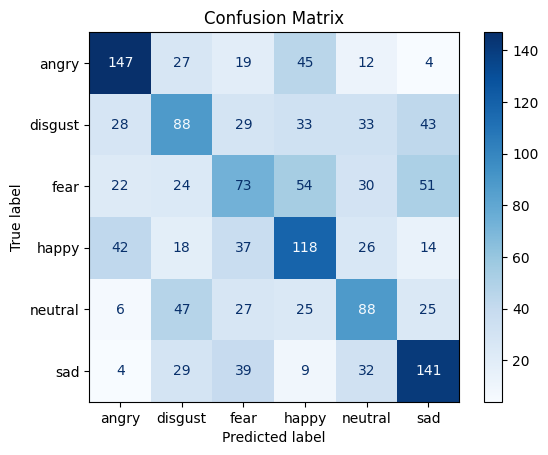


DecisionTree Accuracy: 43.989%
              precision    recall  f1-score   support

       angry       0.59      0.58      0.58       254
     disgust       0.38      0.35      0.36       254
        fear       0.33      0.29      0.31       254
       happy       0.42      0.46      0.44       255
     neutral       0.40      0.40      0.40       218
         sad       0.51      0.56      0.53       254

    accuracy                           0.44      1489
   macro avg       0.44      0.44      0.44      1489
weighted avg       0.44      0.44      0.44      1489



In [10]:
dt_model = DecisionTreeClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('DecisionTree',dt_model,iters=200)

Total Time taken = 2 min 18 sec

Current Accuracy = 36.53%
Best Accuracy = 45.40% at iter=271
Best Model Params Found so far = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None, 'random_state': 560}

Best Preprocessing Params Found so far = {'rs': 120, 'apply_smote': False, 'apply_LDA': True}

Hyperparameter Tuning Done!


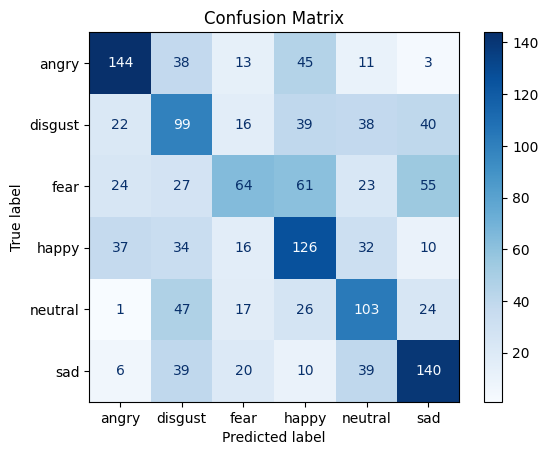


DecisionTree Accuracy: 45.400%
              precision    recall  f1-score   support

       angry       0.62      0.57      0.59       254
     disgust       0.35      0.39      0.37       254
        fear       0.44      0.25      0.32       254
       happy       0.41      0.49      0.45       255
     neutral       0.42      0.47      0.44       218
         sad       0.51      0.55      0.53       254

    accuracy                           0.45      1489
   macro avg       0.46      0.45      0.45      1489
weighted avg       0.46      0.45      0.45      1489



In [11]:
dt_model = DecisionTreeClassifier()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('DecisionTree',dt_model,iters=400,rs=120)

Total Time taken = 28 min 54 sec

Current Accuracy = 48.15%
Best Accuracy = 49.29% at iter=215
Best Model Params Found so far = {'C': 0.06941558636303455, 'kernel': 'linear', 'gamma': 0.00021679938577502276, 'coef0': 0.243470201979273, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'random_state': 530}

Best Preprocessing Params Found so far = {'rs': 559, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


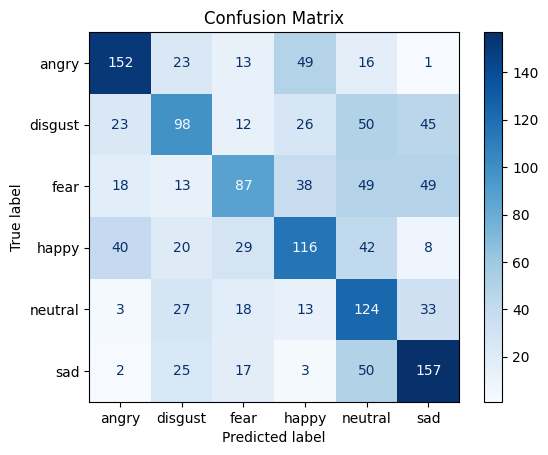


SVM Accuracy: 49.295%
              precision    recall  f1-score   support

       angry       0.64      0.60      0.62       254
     disgust       0.48      0.39      0.43       254
        fear       0.49      0.34      0.40       254
       happy       0.47      0.45      0.46       255
     neutral       0.37      0.57      0.45       218
         sad       0.54      0.62      0.57       254

    accuracy                           0.49      1489
   macro avg       0.50      0.49      0.49      1489
weighted avg       0.50      0.49      0.49      1489



In [12]:
svm_model = SVC()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('SVM',svm_model,iters=300)

Total Time taken = 18 min 28 sec

Current Accuracy = 24.18%
Best Accuracy = 50.17% at iter=76
Best Model Params Found so far = {'C': 0.2883494624116486, 'kernel': 'linear', 'gamma': 5.296800274921653e-05, 'coef0': 0.2620973226971571, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'random_state': 113}

Best Preprocessing Params Found so far = {'rs': 559, 'apply_smote': True, 'apply_LDA': True}

Hyperparameter Tuning Done!


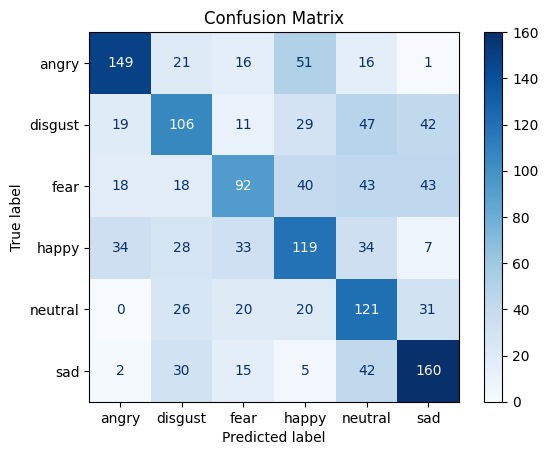


SVM Accuracy: 50.168%
              precision    recall  f1-score   support

       angry       0.67      0.59      0.63       254
     disgust       0.46      0.42      0.44       254
        fear       0.49      0.36      0.42       254
       happy       0.45      0.47      0.46       255
     neutral       0.40      0.56      0.46       218
         sad       0.56      0.63      0.59       254

    accuracy                           0.50      1489
   macro avg       0.51      0.50      0.50      1489
weighted avg       0.51      0.50      0.50      1489



In [13]:
svm_model = SVC()
max_acc,best_model_params,best_prep_params = tune_ML_hppms('SVM',svm_model,iters=150,rs=559)

Total Time taken = 8 min 17 sec

Current Accuracy = 46.68%
Best Accuracy = 49.50% at iter=24
Best Model Params Found so far = {'C': 0.0013293362393075761, 'solver': 'sag', 'class_weight': None, 'penalty': None, 'random_state': 429}

Best Preprocessing Params Found so far = {'rs': 312, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


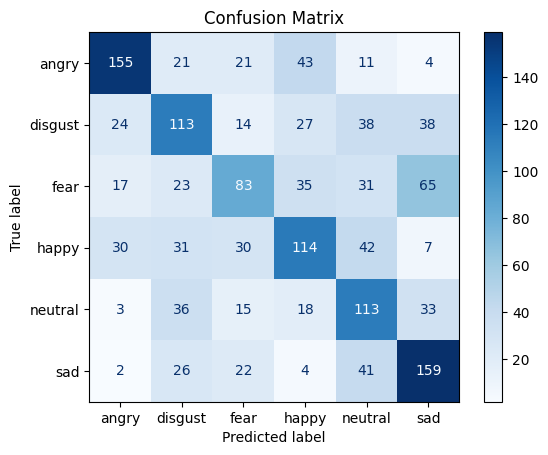


LogisticRegression Accuracy: 49.496%
              precision    recall  f1-score   support

       angry       0.67      0.61      0.64       255
     disgust       0.45      0.44      0.45       254
        fear       0.45      0.33      0.38       254
       happy       0.47      0.45      0.46       254
     neutral       0.41      0.52      0.46       218
         sad       0.52      0.63      0.57       254

    accuracy                           0.49      1489
   macro avg       0.50      0.50      0.49      1489
weighted avg       0.50      0.49      0.49      1489



In [15]:
lr_model = LogisticRegression(max_iter=1000)
max_acc,best_model_params,best_prep_params = tune_ML_hppms('LogisticRegression',lr_model,iters=50)

Total Time taken = 6 min 45 sec

Current Accuracy = 49.03%
Best Accuracy = 49.97% at iter=5
Best Model Params Found so far = {'C': 0.2501102432710276, 'solver': 'lbfgs', 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 767}

Best Preprocessing Params Found so far = {'rs': 312, 'apply_smote': False, 'apply_LDA': False}

Hyperparameter Tuning Done!


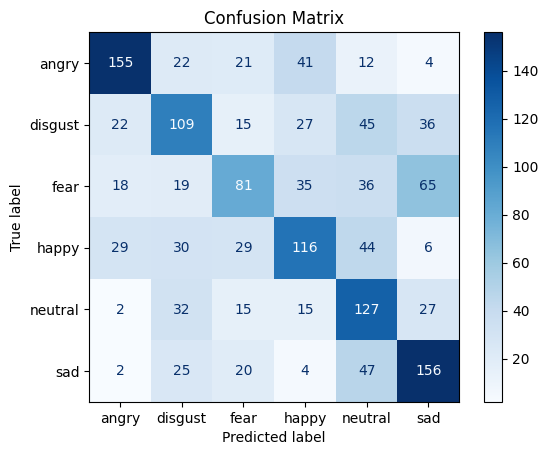


LogisticRegression Accuracy: 49.966%
              precision    recall  f1-score   support

       angry       0.68      0.61      0.64       255
     disgust       0.46      0.43      0.44       254
        fear       0.45      0.32      0.37       254
       happy       0.49      0.46      0.47       254
     neutral       0.41      0.58      0.48       218
         sad       0.53      0.61      0.57       254

    accuracy                           0.50      1489
   macro avg       0.50      0.50      0.50      1489
weighted avg       0.50      0.50      0.50      1489



In [7]:
lr_model = LogisticRegression(max_iter=1000)
max_acc,best_model_params,best_prep_params = tune_ML_hppms('LogisticRegression',lr_model,iters=50,rs=312)

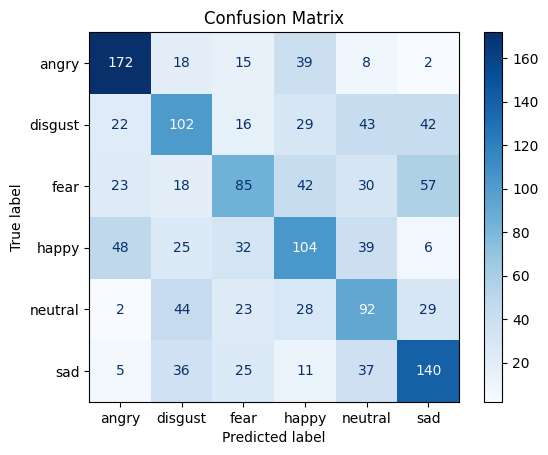


Random Forest Accuracy: 46.676%
              precision    recall  f1-score   support

       angry       0.63      0.68      0.65       254
     disgust       0.42      0.40      0.41       254
        fear       0.43      0.33      0.38       255
       happy       0.41      0.41      0.41       254
     neutral       0.37      0.42      0.39       218
         sad       0.51      0.55      0.53       254

    accuracy                           0.47      1489
   macro avg       0.46      0.47      0.46      1489
weighted avg       0.46      0.47      0.46      1489



In [9]:
rf_model = RandomForestClassifier(n_estimators=400,random_state=42)
acc_rf = preprocess_split_train_test(df,rf_model,'Random Forest',rs=42)

In [ ]:
rf_model = RandomForestClassifier()
max_acc,best_params = tune_ML_hppms('RandomForest',rf_model,iters=30)

Total Time taken = 22 min 12 sec

Current Accuracy = 45.40%
Best Accuracy = 50.37% at iter=4
Best Model Params Found so far = {'n_estimators': 326, 'max_depth': 45, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'class_weight': None, 'random_state': 557}

Best Preprocessing Params Found so far = {'rs': 693, 'apply_smote': True, 'apply_LDA': False}

Iter No. - 27
Model Params = {'n_estimators': 86, 'max_depth': 46, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'random_state': 267}
Preprocessing Params = {'rs': 62, 'apply_smote': True, 'apply_LDA': False}
Time taken = 2 min 10 sec
